# Quality control and clustering of scRNA-seq data from endometriosis and control samples across eutopic tissue (GSE179640)

In [1]:
from pathlib import Path
import scanpy as sc
import pandas as pd
import numpy as np
!pip install openpyxl

In [2]:
base = Path("/home/katwre/projects/Endometriosis/data/GSE179640_RAW/")
files = list(base.glob("*.h5"))

adatas = []
for f in files:
    ad = sc.read_10x_h5(f)
    ad.var_names_make_unique()
    ad.obs["sample_id"] = f.stem
    adatas.append(ad)

adata_all = adatas[0].concatenate(
    *adatas[1:],
    batch_key="sample",
    batch_categories=[f.stem for f in files]
)
adata_all

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_du

AnnData object with n_obs × n_vars = 58897 × 33538
    obs: 'sample_id', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
adata_all.obs["sample_id"].value_counts()

sample_id
GSM6102533_C02_Ctrl_filtered_feature_bc_matrix    7801
GSM6102537_E01_EuE_filtered_feature_bc_matrix     7665
GSM6102534_C03_Ctrl_filtered_feature_bc_matrix    5531
GSM6102543_E03_EuE_filtered_feature_bc_matrix     5302
GSM6102540_E02_EuE_filtered_feature_bc_matrix     5277
GSM6102560_E09_EuE_filtered_feature_bc_matrix     5255
GSM6102551_E06_EuE_filtered_feature_bc_matrix     5226
GSM6102532_C01_Ctrl_filtered_feature_bc_matrix    4133
GSM6102546_E04_EuE_filtered_feature_bc_matrix     3819
GSM6102554_E07_EuE_filtered_feature_bc_matrix     3078
GSM6102549_E05_EuE_filtered_feature_bc_matrix     3030
GSM6102555_E08_EuE_filtered_feature_bc_matrix     2780
Name: count, dtype: int64

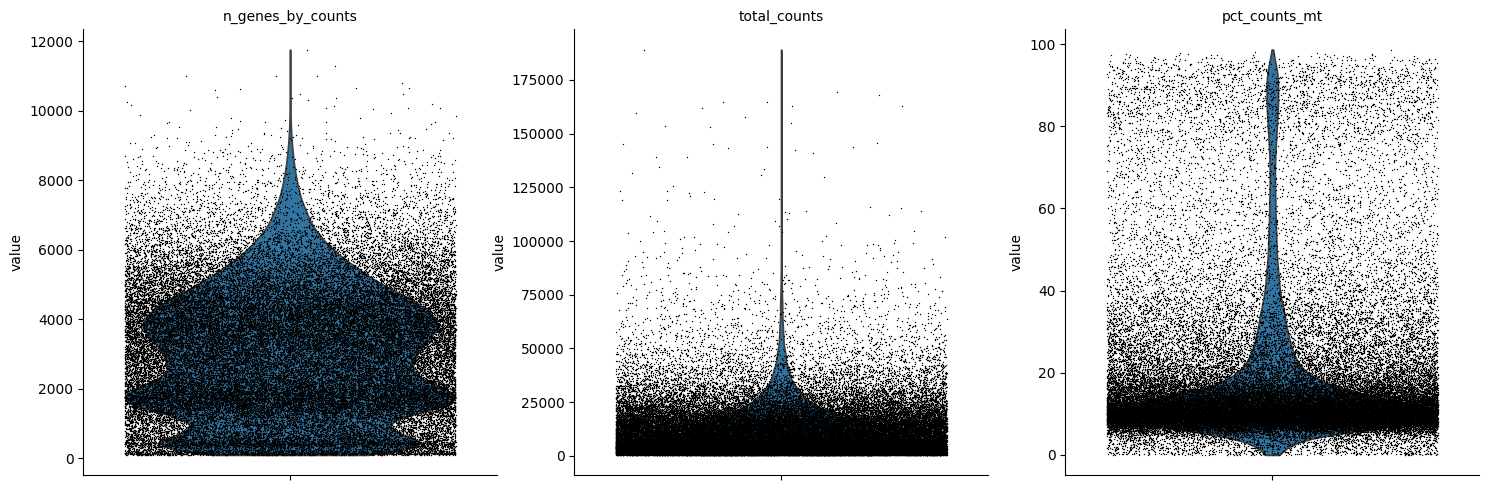

In [ ]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_all.var["mt"] = adata_all.var_names.str.startswith("MT-")
# ribosomal genes
adata_all.var["ribo"] = adata_all.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_all.var["hb"] = adata_all.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(adata_all, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

# filter cells with less than 100 genes expressed and genes that are detected in less than 3 cells.
sc.pp.filter_cells(adata_all, min_genes=100)
sc.pp.filter_genes(adata_all, min_cells=3)


sc.pl.violin(
    adata_all,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


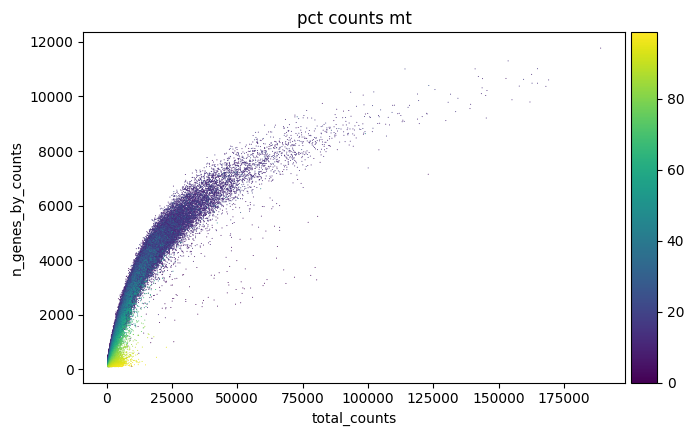

In [8]:
sc.pl.scatter(adata_all, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [9]:
# Doublet detection
sc.pp.scrublet(adata_all, batch_key="sample")

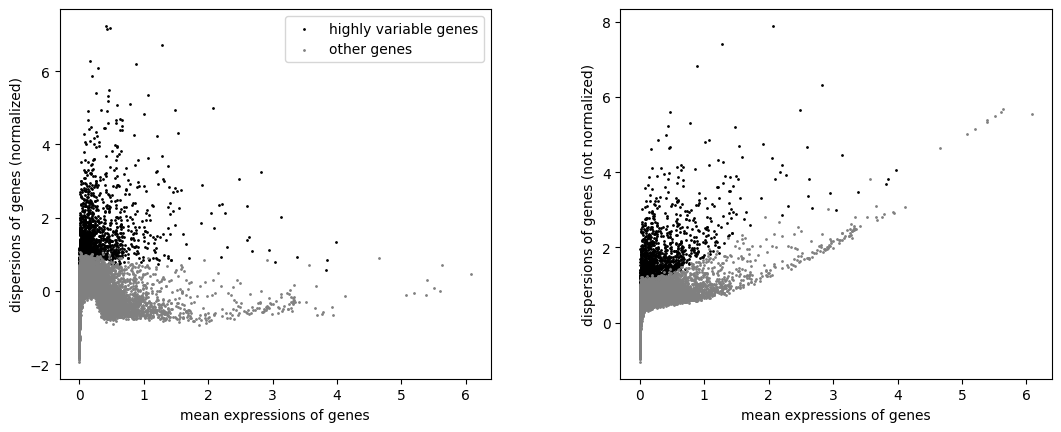

In [13]:
# Normalization
# Saving count data
adata_all.layers["counts"] = adata_all.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata_all)
# Logarithmize the data
sc.pp.log1p(adata_all)

# Feature selection
# we want to reduce the dimensionality of the dataset and only include the most informative genes.

# Identify highly variable genes
sc.pp.highly_variable_genes(adata_all, n_top_genes=2000, batch_key="sample")
sc.pl.highly_variable_genes(adata_all)

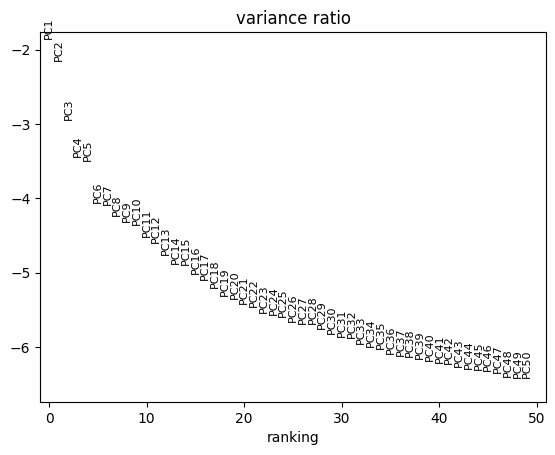

In [14]:
# Dimensionality Reduction
sc.tl.pca(adata_all)
sc.pl.pca_variance_ratio(adata_all, n_pcs=50, log=True)

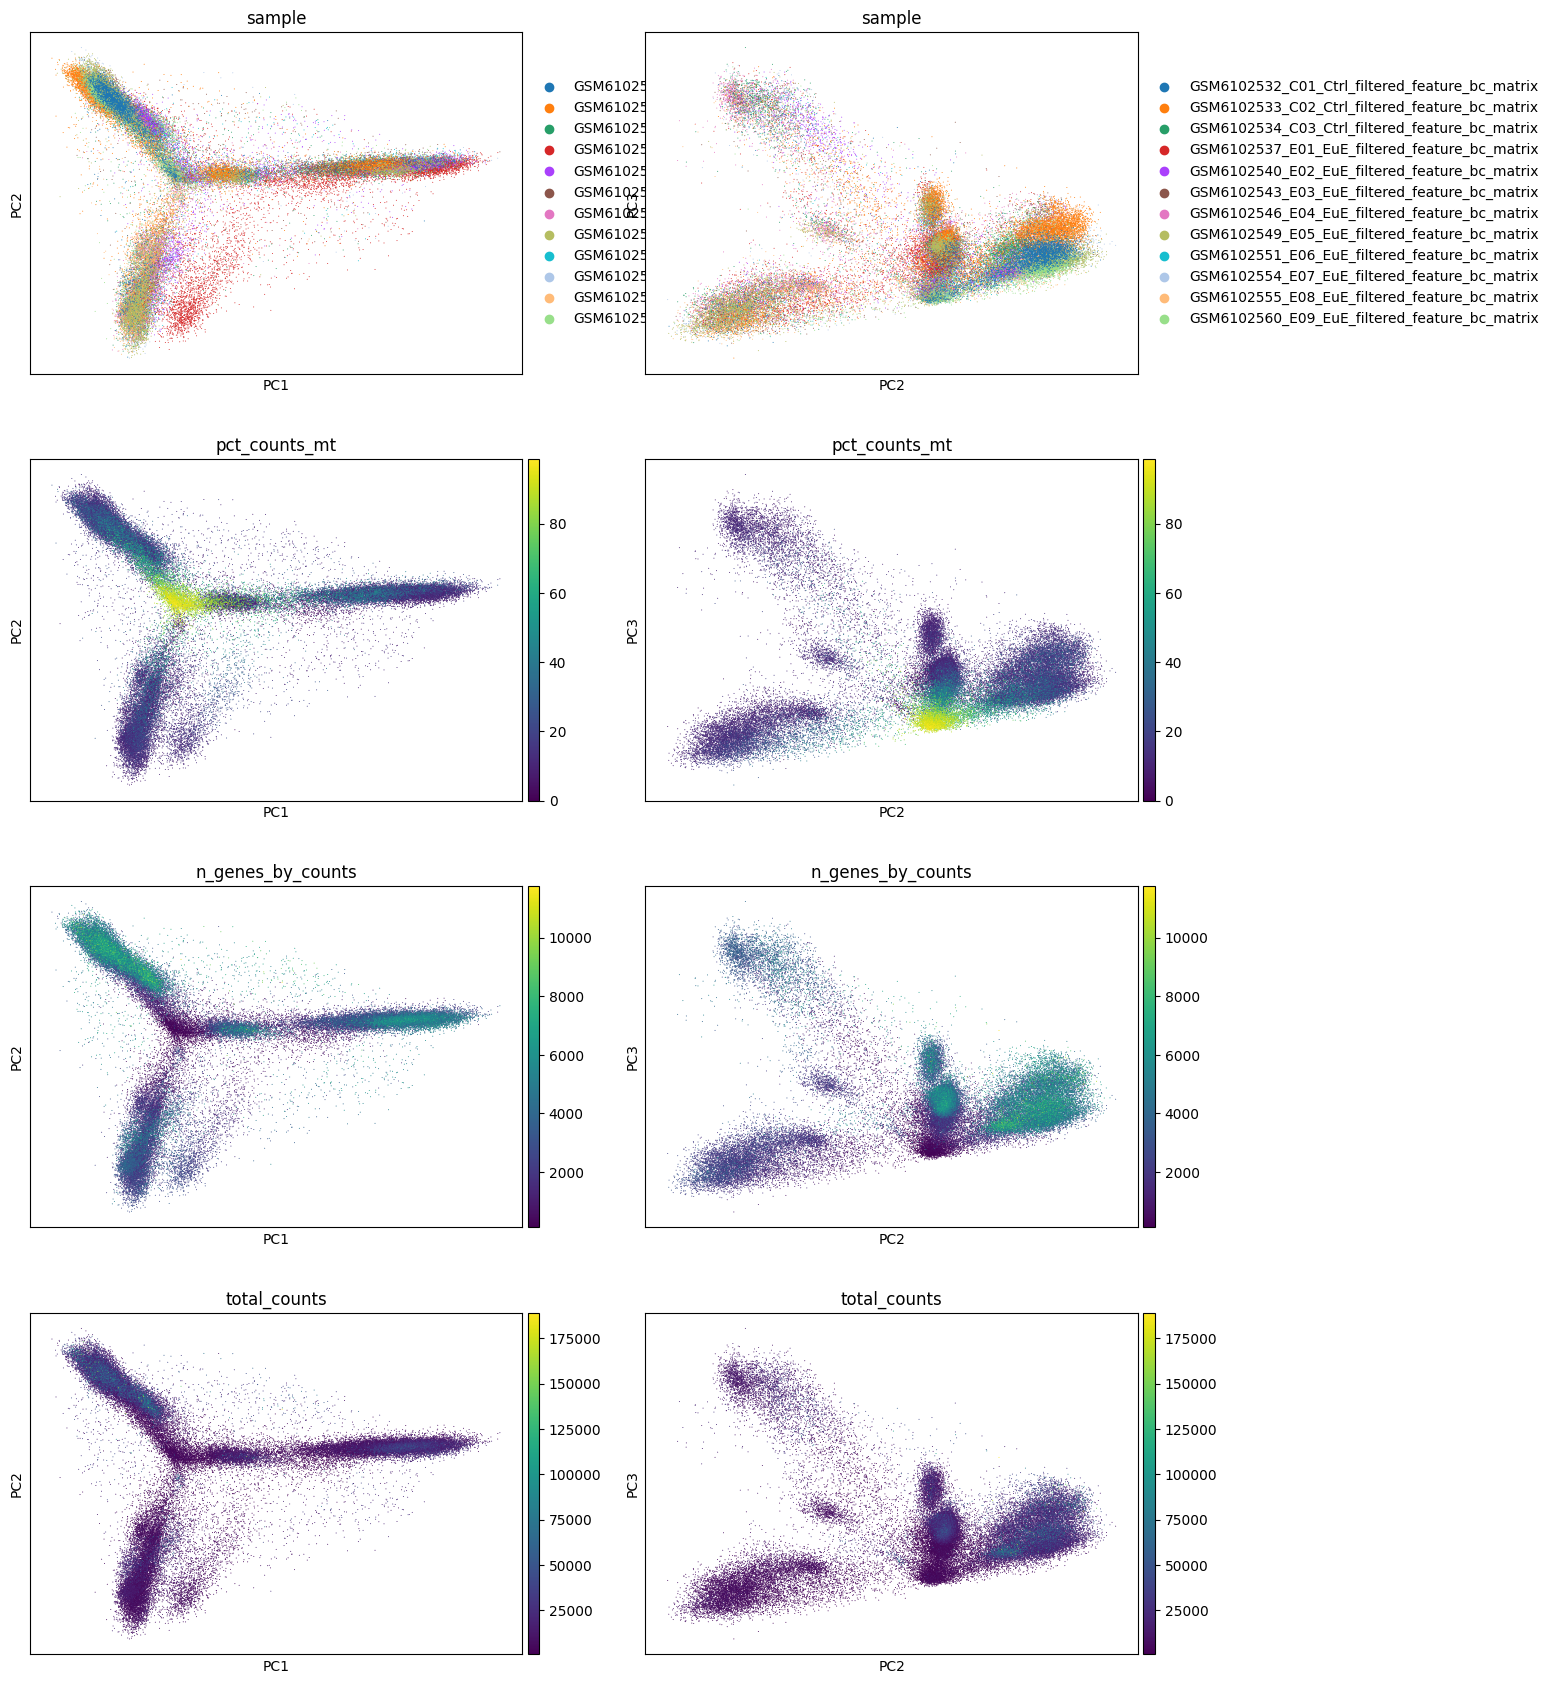

In [15]:
sc.pl.pca(
    adata_all,
    color=["sample", "pct_counts_mt", "n_genes_by_counts", "total_counts"],
    components=["1,2", "2,3"],
    ncols=2,
    size=2,
)

/home/katwre/.local/share/virtualenvs/Endometriosis-pNZatqoH/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


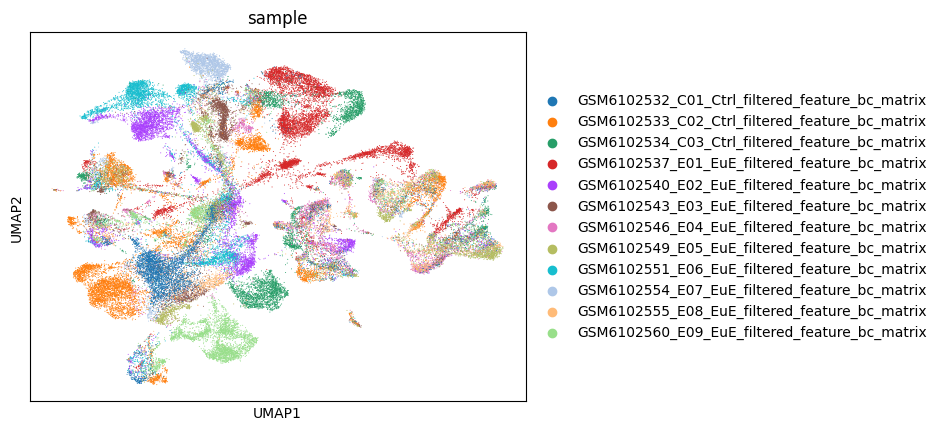

In [16]:
# Nearest neighbor graph construction and visualization
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(
    adata_all,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

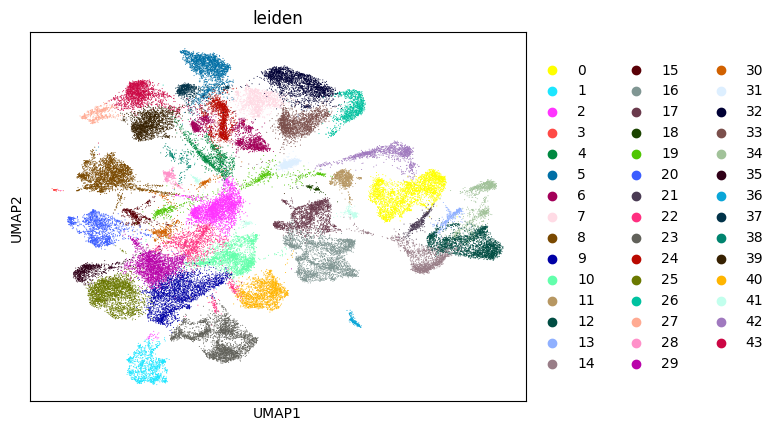

In [17]:
# Clustering

# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
sc.tl.leiden(adata_all, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_all, color=["leiden"])

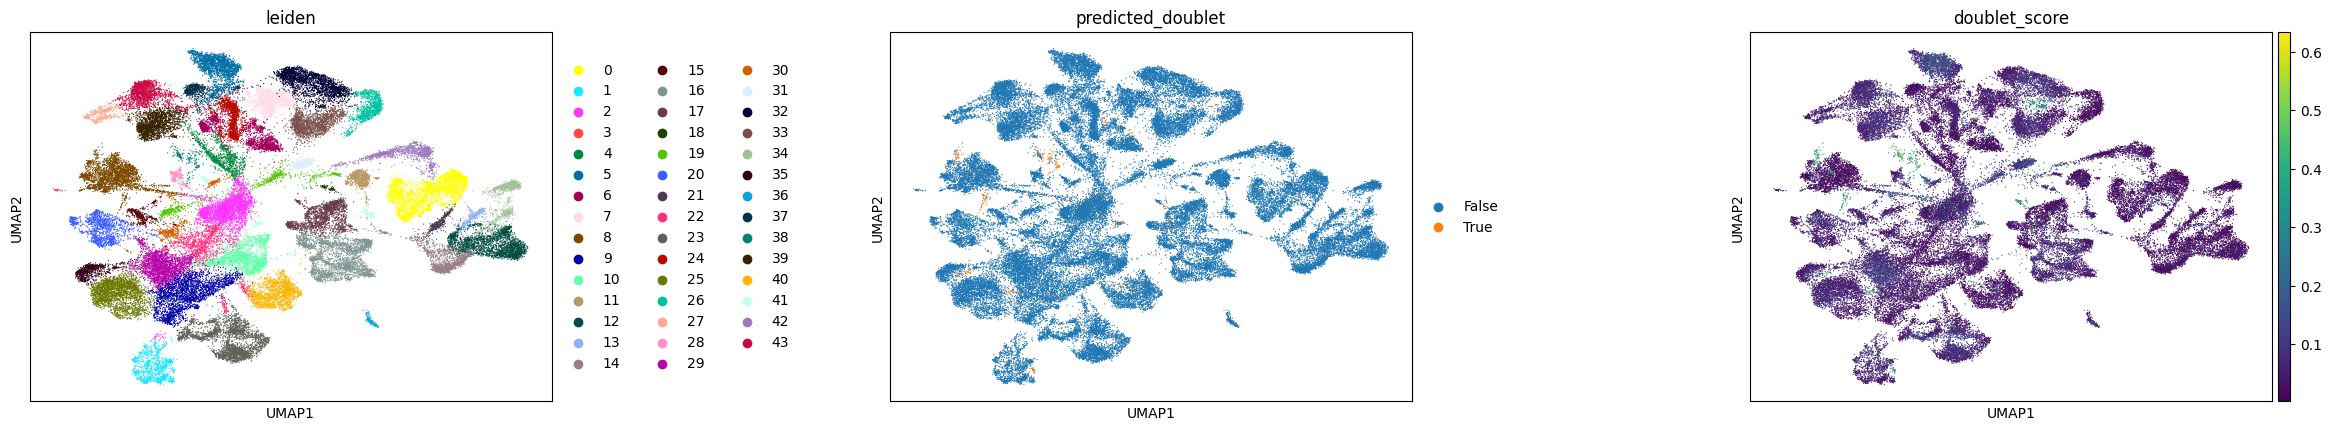

In [18]:
# Re-assess quality control and cell filtering
sc.pl.umap(
    adata_all,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

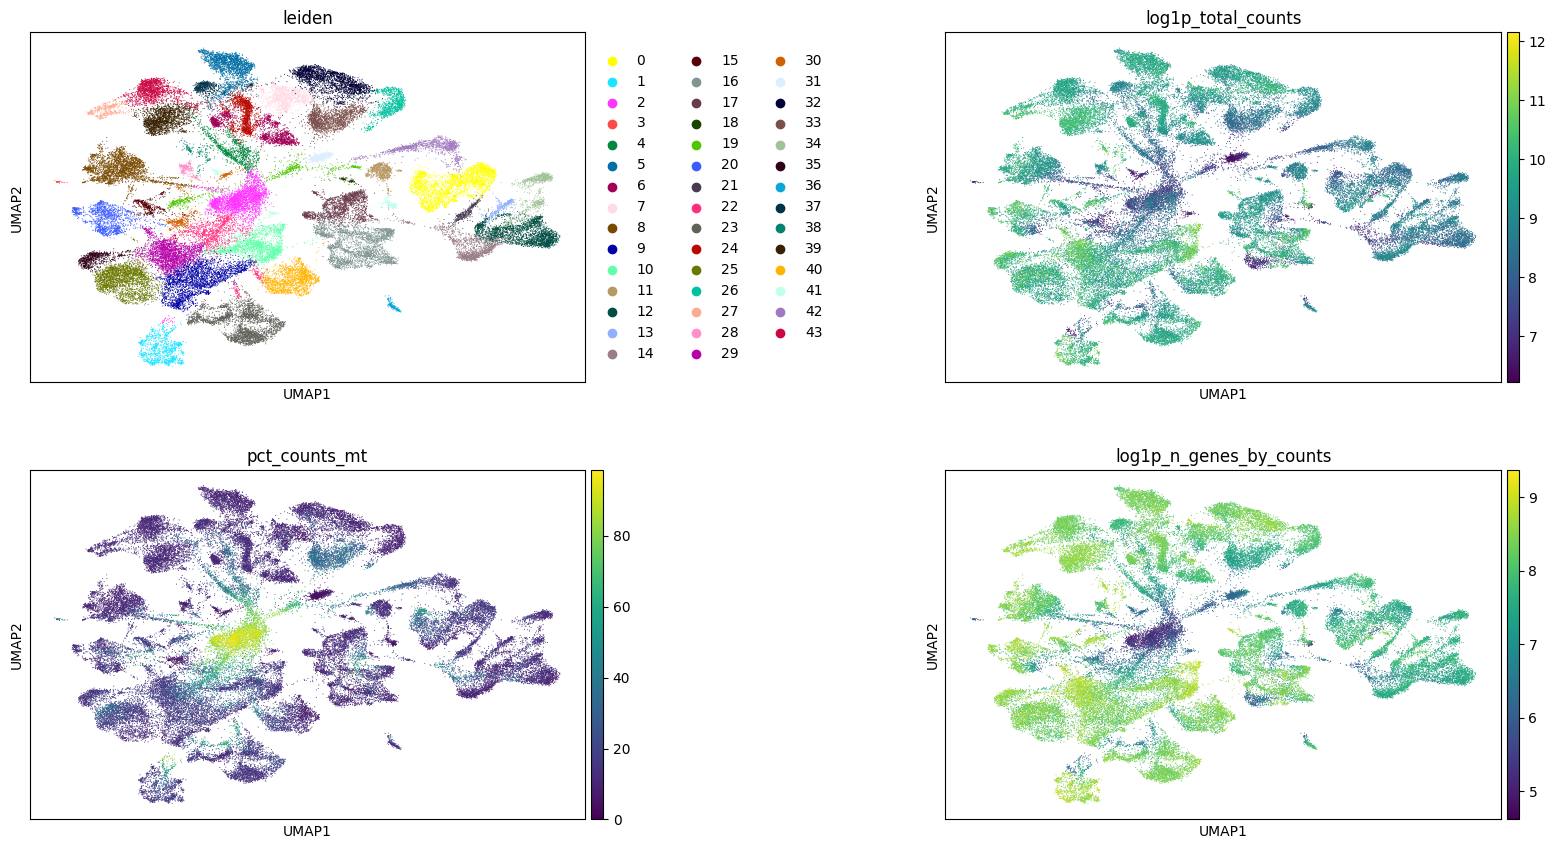

In [ ]:
sc.pl.umap(
    adata_all,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

UMAP places clusters in 2D space based on similarity - high-mito cells are “similar” in their damaged profile. This pattern is typical of debris-laden droplets or dying cells. It's not suprising in the data derived from endometrium. I'm gong to filter cells by mitochondrial percentage.

In [21]:
adata_all = adata_all[adata_all.obs.pct_counts_mt < 15]

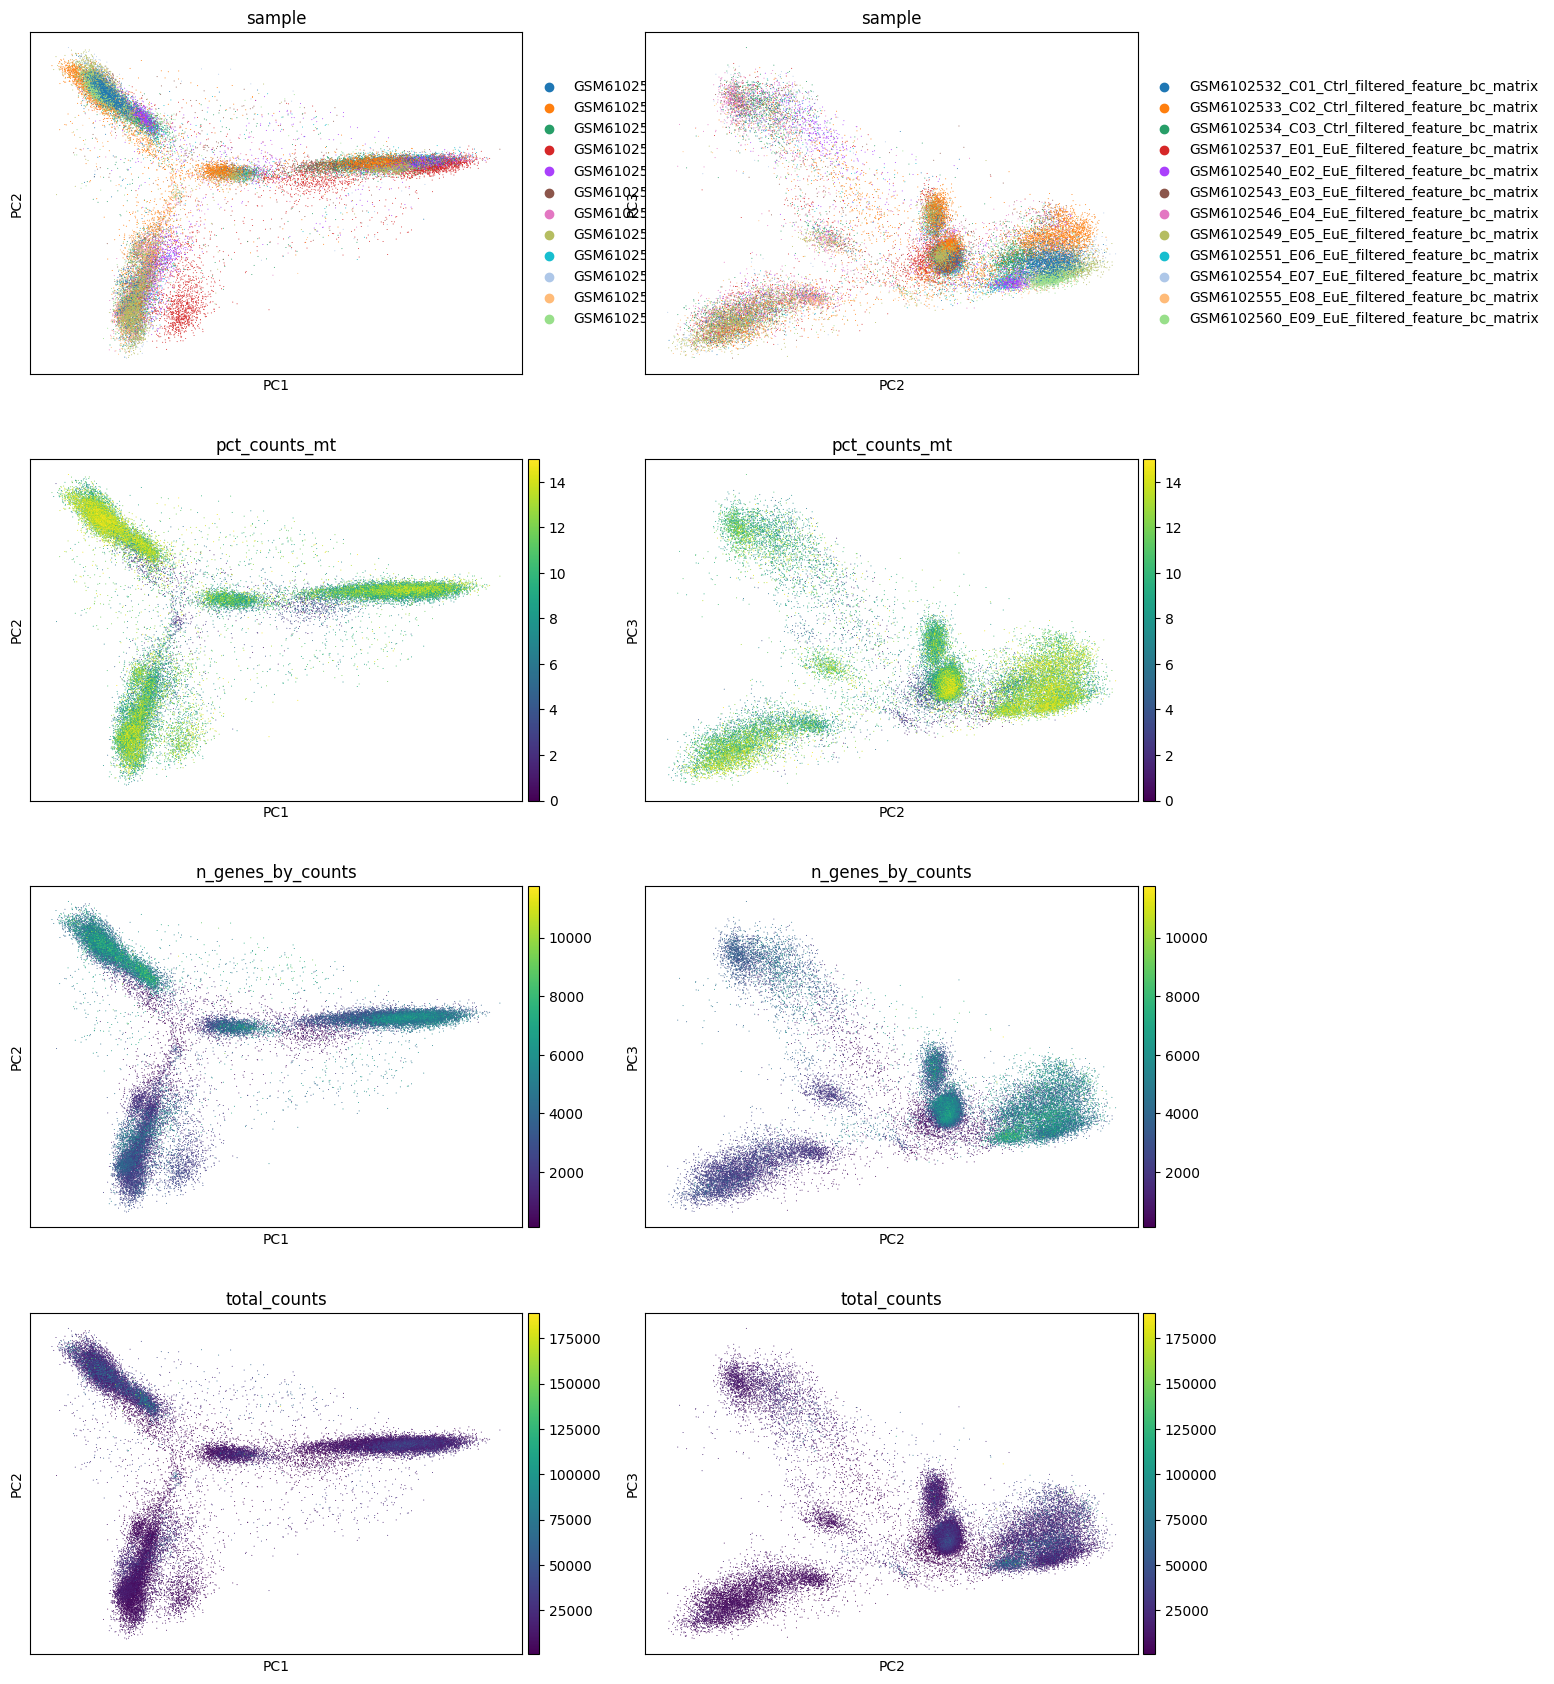

In [22]:
sc.pl.pca(
    adata_all,
    color=["sample", "pct_counts_mt", "n_genes_by_counts", "total_counts"],
    components=["1,2", "2,3"],
    ncols=2,
    size=2,
)

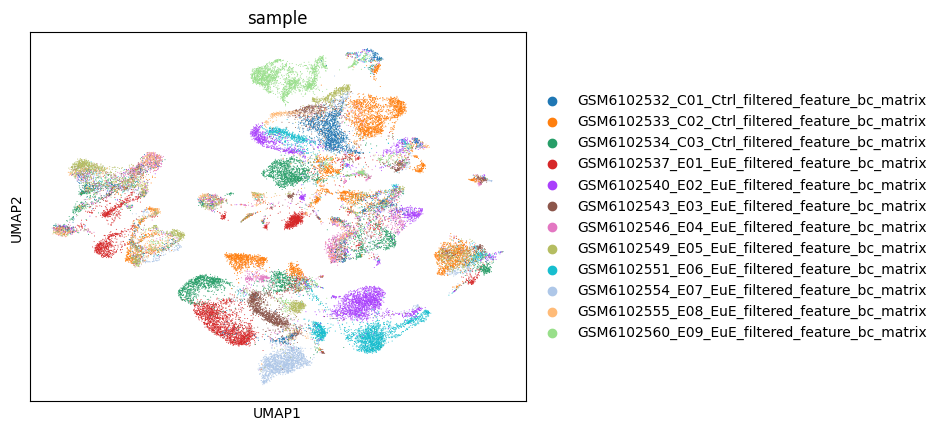

In [23]:
# Nearest neighbor graph construction and visualization
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(
    adata_all,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

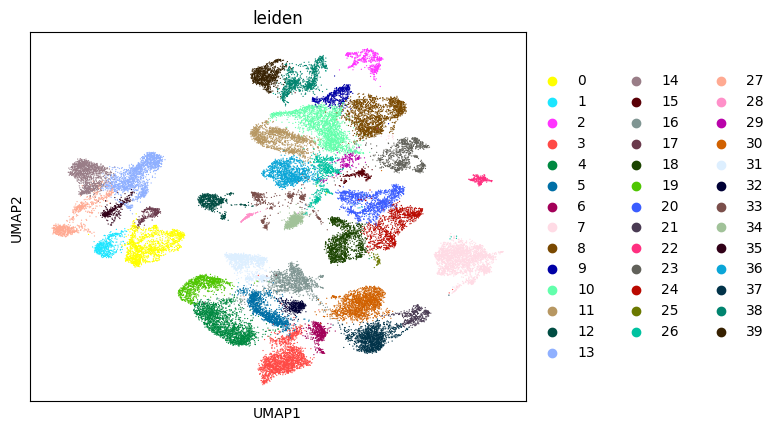

In [24]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster,
# especially for larger datasets
sc.tl.leiden(adata_all, flavor="igraph", n_iterations=2)
sc.pl.umap(adata_all, color=["leiden"])

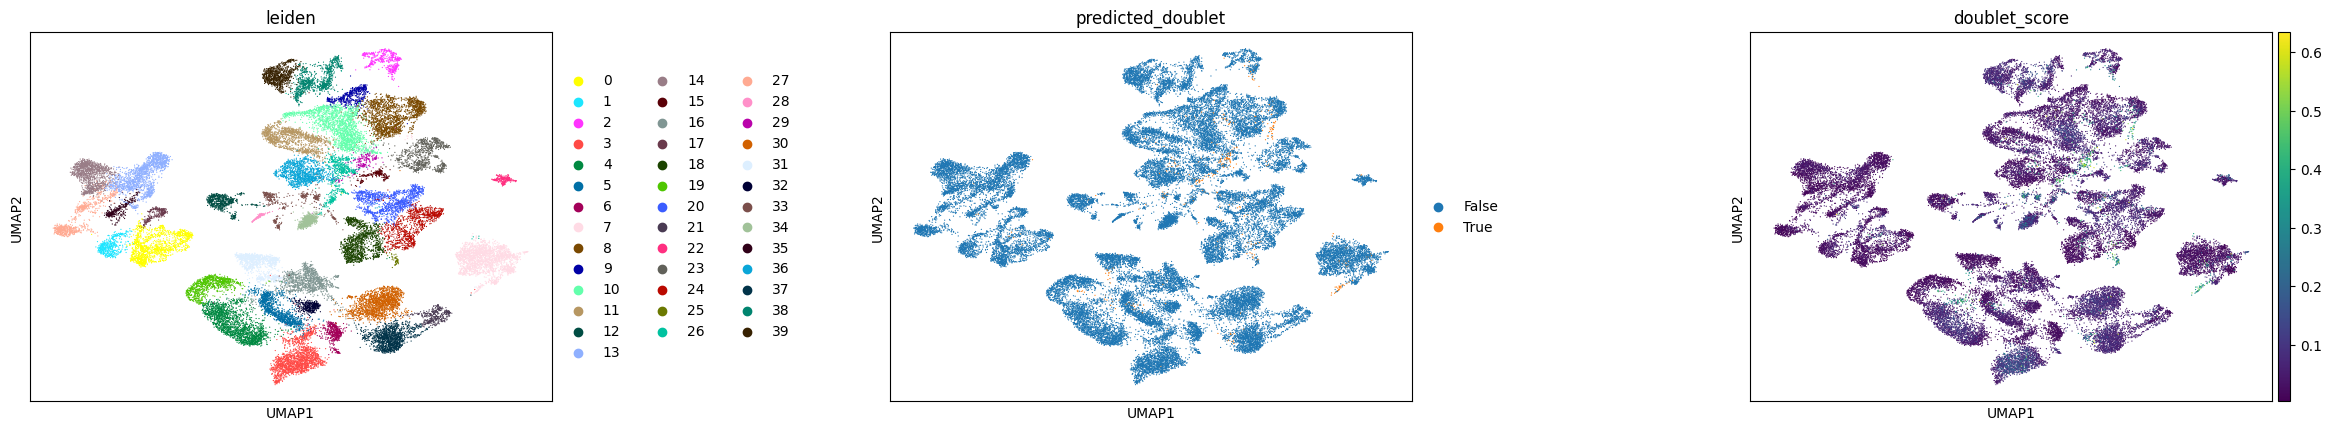

In [25]:
# Re-assess quality control and cell filtering
sc.pl.umap(
    adata_all,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

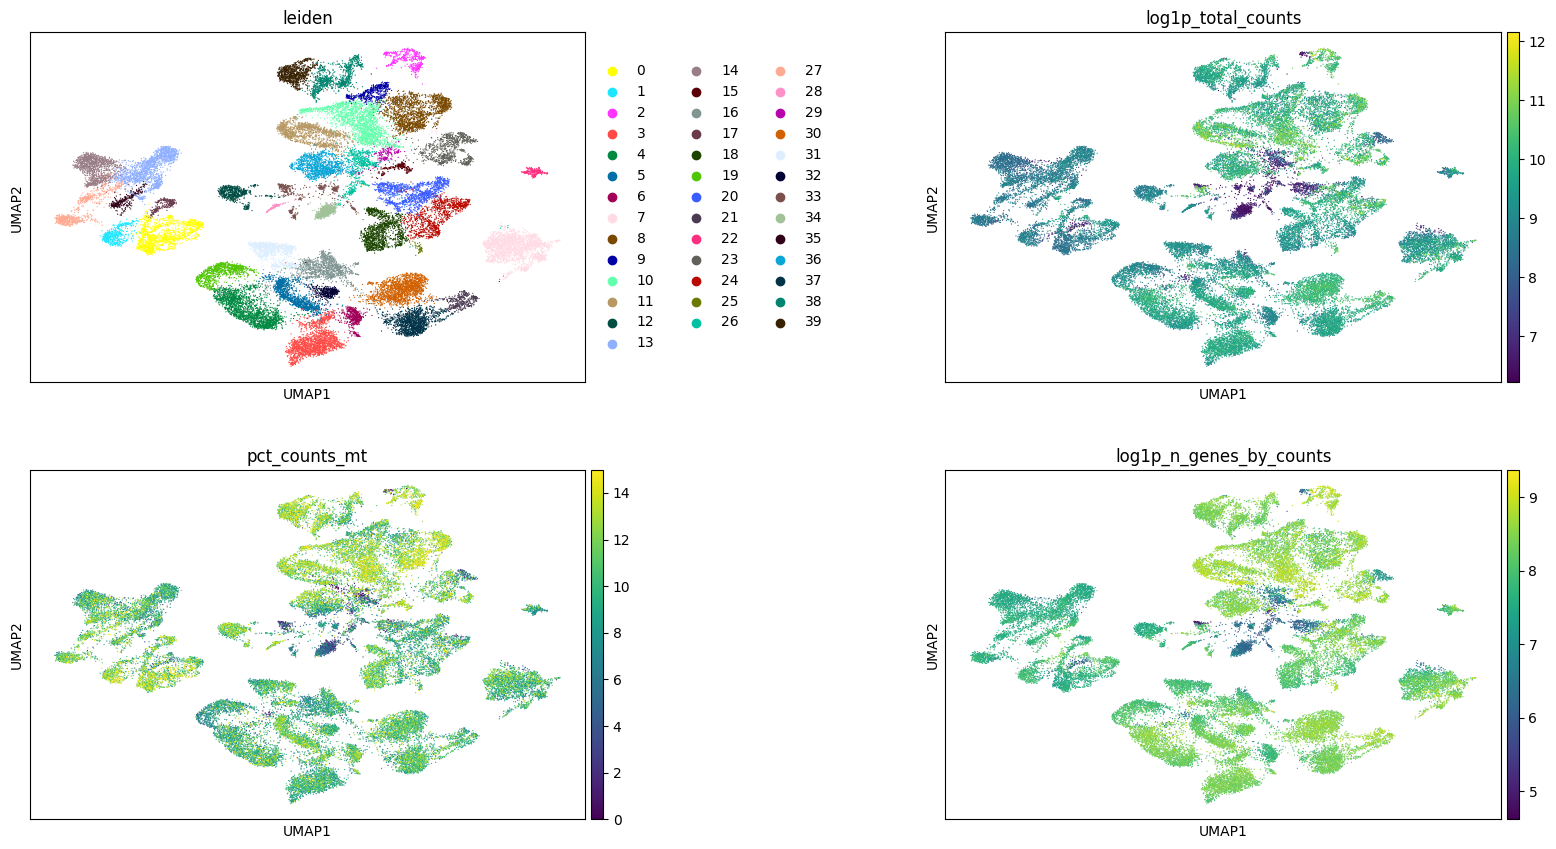

In [26]:
sc.pl.umap(
    adata_all,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

In [ ]:
adata_all.write_h5ad(
    "/home/katwre/projects/Endometriosis/data/processed/01_processed_qc_clustering_GSE179640_RAW.h5ad"
)